# Sex-Specific Alzheimer's Disease Modelling Experimentations

## Set-up and Cleaning

In [307]:
# === Load and clean data ===
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from scipy import stats

#p_value = ttest_rel(baseline_fold_metrics, sex_specific_fold_metrics).pvalue




In [308]:
# Load OASIS dataset
df = pd.read_csv("oasis_longitudinal.csv")
print(df)

    Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  \
0    OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87   
1    OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88   
2    OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75   
3    OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76   
4    OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80   
..         ...            ...          ...    ...       ...  ..  ...  ...   
368  OAS2_0185  OAS2_0185_MR2     Demented      2       842   M    R   82   
369  OAS2_0185  OAS2_0185_MR3     Demented      3      2297   M    R   86   
370  OAS2_0186  OAS2_0186_MR1  Nondemented      1         0   F    R   61   
371  OAS2_0186  OAS2_0186_MR2  Nondemented      2       763   F    R   63   
372  OAS2_0186  OAS2_0186_MR3  Nondemented      3      1608   F    R   65   

     EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
0      14  2.0  27.0  0.0  

In [309]:
# Fill missing SES and MMSE values
df['SES'] = df['SES'].fillna(df['SES'].median())
df['MMSE'] = df['MMSE'].fillna(df['MMSE'].mean())

In [310]:
# Convert labels to binary classification: demented = 1, nondemented = 0
df['Group'] = df['Group'].replace("Converted", "Demented")
df['Group'] = df['Group'].map({"Demented": 1, "Nondemented": 0})

In [311]:
# Define features and dropping missing values
my_features = ['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
df_clean = df.dropna(subset=my_features + ['Group', 'M/F'])

## Repeated Train/Test Evaluation Function

In [313]:

# === REPEATED TRAIN/TEST EVALUATION ===

def repeated_evaluation(model, X, y, label, sex=None, sex_filter=None, groups=None, n_splits=5, n_repeats=5):
    fold_metrics = []
    for repeat in range(n_repeats):
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42 + repeat)
        for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            scaler = StandardScaler() 
            X_train_scaled = scaler.fit_transform(X_train) 
            X_test_scaled = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled) [:, 1]
        if sex is not None and sex_filter is not None:
            test_sex = sex.iloc[test_idx]
            mask = test_sex == sex_filter
            if not mask.any():
                continue
            y_test = y_test[mask]
            y_pred = y_pred[mask]
            y_proba = y_proba[mask]

        fold_metrics.append({
            'repeat': repeat,
            'fold': fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba)
        })

    metrics_df = pd.DataFrame(fold_metrics)
    metrics = metrics_df[['accuracy', 'f1', 'precision', 'recall', 'roc_auc']]
    means = metrics.mean()
    stds = metrics.std()
    summary = [
        label,
        means['accuracy'], stds['accuracy'],
        means['f1'], stds['f1'],
        means['precision'], stds['precision'],
        means['recall'], stds['recall'],
        means['roc_auc'], stds['roc_auc']
    ]
   
    return summary, metrics_df

In [314]:
results = []
results_folds = {}
X_all = df_clean[my_features]
y_all = df_clean['Group']
sex_all = df_clean['M/F']
groups_all = df_clean['Subject ID']

## Logistic Regression and Random Forest Classifier Models

In [316]:

# === General models ===

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-All", groups=groups_all)
results.append(summary)
results_folds["Gen-LR-All"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-All", groups=groups_all)
results.append(summary)
results_folds["Gen-RF-All"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-M", sex=sex_all, sex_filter='M', groups=groups_all)
results.append
results_folds["Gen-LR-M"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-F", sex=sex_all, sex_filter='F', groups=groups_all)
results.append
results_folds["Gen-LR-F"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-M", sex=sex_all, sex_filter='M', groups=groups_all)
results.append
results_folds["Gen-RF-M"] = folds
summary, fold = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-F", sex=sex_all, sex_filter='F', groups=groups_all)
results.append
results_folds["Gen-RF-F"] = folds


In [329]:

# === Sex specific models ===

df_male = df_clean[df_clean['M/F'] == 'M']
df_female = df_clean[df_clean['M/F'] == 'F']
groups_f = df_female['Subject ID']
groups_m = df_male['Subject ID']

X_m, y_m = df_male[my_features], df_male['Group']

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_m, y_m, "Male-LR-M", groups=groups_m)
results.append(summary)
results_folds["Male-LR-M"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_m, y_m, "Male-RF-M", groups=groups_m)
results.append(summary)
results_folds["Male-RF-M"] = folds

X_f, y_f = df_female[my_features], df_female['Group']

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_f, y_f, "Female-LR-F", groups=groups_f)
results.append(summary)
results_folds["Female-LR-F"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_f, y_f, "Female-RF-F", groups=groups_f)
results.append(summary)
results_folds["Female-RF-F"] = folds

In [330]:

# === Results Table ===
columns =['Model', 'Accuracy_mean', 'Accuracy_std', 'F1_mean', 'F1_std', 'Precision_mean', 'Precision_std', 'Recall_mean', 'Recall_std', 'AUC_mean', 'AUC_std']
results_table = pd.DataFrame(results, columns=columns)
n_splits, n_repeats = 5, 5
metrics = ['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']
N = n_splits * n_repeats
for metric in metrics:
    se = results_table[f'{metric}_std'] / np.sqrt(N)
    results_table[f'{metric}_ci_lower'] = results_table[f'{metric}_mean'] - 1.96 * se
    results_table[f'{metric}_ci_upper'] = results_table[f'{metric}_mean'] + 1.96 * se
print(results_table)


         Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std  \
0   Gen-LR-All       0.940433      0.015127  0.935406  0.018655   
1   Gen-RF-All       0.945530      0.017214  0.941044  0.022994   
2    Male-LR-M       0.970289      0.038332  0.976566  0.029948   
3    Male-LR-M       0.970289      0.038332  0.976566  0.029948   
4    Male-RF-M       0.930390      0.047504  0.944774  0.038695   
5  Female-LR-F       0.959723      0.039251  0.921754  0.081457   
6  Female-RF-F       0.936847      0.030709  0.891209  0.069142   

   Precision_mean  Precision_std  Recall_mean  Recall_std  AUC_mean  ...  \
0        0.986406       0.018655     0.889599    0.023265  0.971773  ...   
1        0.981644       0.017308     0.903995    0.032869  0.959873  ...   
2        0.990476       0.021296     0.965035    0.059080  0.989091  ...   
3        0.990476       0.021296     0.965035    0.059080  0.989091  ...   
4        0.932308       0.084510     0.965035    0.059080  0.976938  ...   
5      

## XGBOOST models

In [335]:
xgb_results = []
xgb_fold_results = {}
xgb_model = XGBClassifier(eval_metric='logloss')

summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-All', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-All'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-M', sex=sex_all, sex_filter='M', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-F', sex=sex_all, sex_filter='F', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-F'] = folds

summary, folds = repeated_evaluation(xgb_model, X_m, y_m, 'Male-XGB-M', groups=groups_m)
xgb_results.append(summary)                  
xgb_fold_results['Male-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_f, y_f, 'Female-XGB-F', groups=groups_f)
xgb_results.append(summary)                  
xgb_fold_results['Female-XGB-F'] = folds



In [336]:
xgb_results_table = pd.DataFrame(xgb_results, columns=columns)
n_splits, n_repeats = 5, 5
N = n_splits * n_repeats
for metric in metrics:
    se = xgb_results_table[f'{metric}_std'] / np.sqrt(N)
    xgb_results_table[f'{metric}_ci_lower'] = xgb_results_table[f'{metric}_mean'] - 1.96 * se
    xgb_results_table[f'{metric}_ci_upper'] = xgb_results_table[f'{metric}_mean'] + 1.96 * se
print(xgb_results_table)

          Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std  \
0   Gen-XGB-All       0.940637      0.033243  0.934190  0.044696   
1     Gen-XGB-M       0.947964      0.037605  0.961388  0.028790   
2     Gen-XGB-F       0.932364      0.053914  0.875929  0.115393   
3    Male-XGB-M       0.958673      0.035301  0.966515  0.027974   
4  Female-XGB-F       0.913392      0.032533  0.867011  0.028357   

   Precision_mean  Precision_std  Recall_mean  Recall_std  AUC_mean  ...  \
0        0.956288       0.054158     0.913946    0.046383  0.949987  ...   
1        0.957609       0.051041     0.966375    0.019165  0.974155  ...   
2        0.949206       0.070452     0.817803    0.152650  0.907991  ...   
3        0.971292       0.041575     0.965035    0.059080  0.976713  ...   
4        0.913621       0.088210     0.843312    0.121328  0.902926  ...   

   Accuracy_ci_lower  Accuracy_ci_upper  F1_ci_lower  F1_ci_upper  \
0           0.927606           0.953668     0.916670     0.951711

## Support Vector Machine and Voting Classifier Models 

In [338]:
svm_vote_results = []
svm_vote_fold_results = {}
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

# === SVM general models ===
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-All', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-All'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-M', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-M'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-F', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-F'] = folds

# === SVM sex-specific models ===
summary, folds = repeated_evaluation(svm_model, X_m, y_m, 'Male-SVM-M', groups=groups_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-SVM-M'] = folds

summary, folds = repeated_evaluation(svm_model, X_f, y_f, 'Female-SVM-F', groups=groups_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-SVM-F'] = folds

In [339]:
# === Voting Classifier Set-up ===

voting_estimators =[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)),
]
voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')

    

In [344]:
# === VC general models ===
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VOTE-All', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VOTE-All'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VOTE-M', sex=sex_all, sex_filter='M', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VOTE-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VOTE-F', sex=sex_all, sex_filter='F', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VOTE-F'] = folds
                                         
# === VC sex-specific models
summary, folds = repeated_evaluation(voting_clf, X_m, y_m, 'Male-VOTE-M', groups=groups_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-VOTE-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_f, y_f, 'Female-VOTE-F', groups=groups_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-VOTE-F'] = folds


In [345]:
# === SVM and VC results ===

svm_vote_results_table = pd.DataFrame(svm_vote_results, columns=columns)
n_splits, n_repeats = 5, 5
N = n_splits * n_repeats
for metric in metrics:
    se = svm_vote_results_table[f'{metric}_std'] / np.sqrt(N)
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] - 1.96 * se
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] + 1.96 * se
print(svm_vote_results_table)

           Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std  \
0    Gen-SVM-All       0.937801      0.017447  0.932609  0.021757   
1      Gen-SVM-M       0.937801      0.017447  0.932609  0.021757   
2      Gen-SVM-F       0.937801      0.017447  0.932609  0.021757   
3     Male-SVM-M       0.969595      0.054160  0.976078  0.043368   
4   Female-SVM-F       0.954845      0.034183  0.911228  0.071625   
5   Gen-VOTE-All       0.940433      0.015127  0.935406  0.018655   
6     Gen-VOTE-M       0.965453      0.013011  0.973939  0.010982   
7     Gen-VOTE-F       0.918739      0.027483  0.858285  0.056212   
8    Male-VOTE-M       0.975845      0.040627  0.981444  0.031689   
9  Female-VOTE-F       0.954845      0.034183  0.912231  0.072290   

   Precision_mean  Precision_std  Recall_mean  Recall_std  AUC_mean   AUC_std  \
0        0.980357       0.028516     0.889599    0.023265  0.956426  0.017748   
1        0.980357       0.028516     0.889599    0.023265  0.956426  0.017748 

## Visually Assessing Model Accuracies - Initial Look

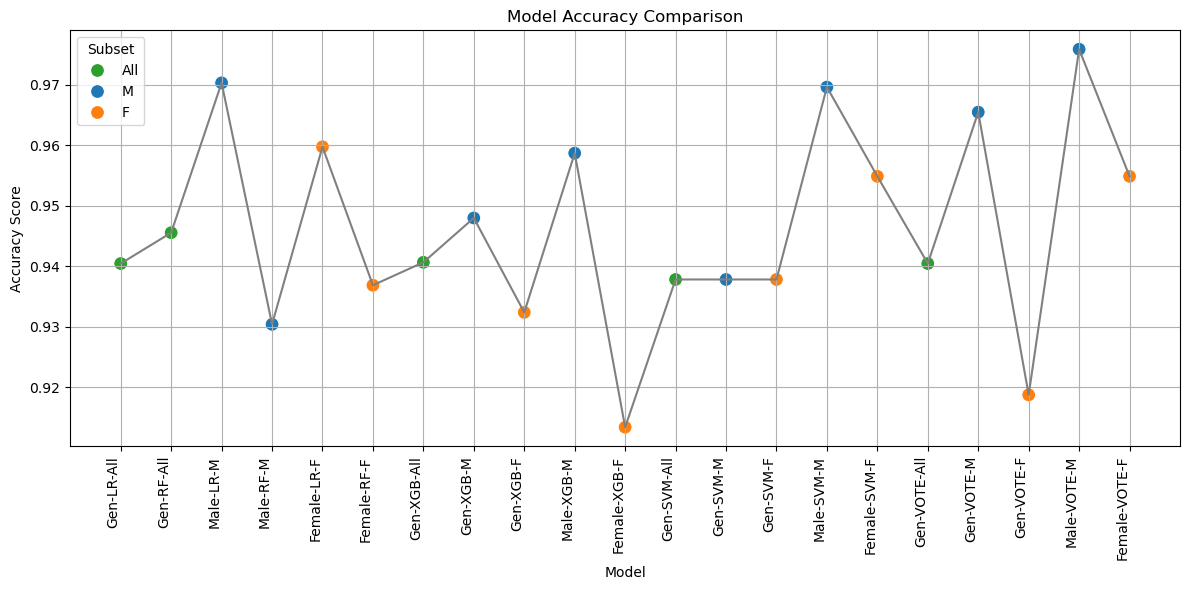

In [347]:
all_results_table = pd.concat([results_table, xgb_results_table,svm_vote_results_table], ignore_index=True)
all_results_table['Subset'] = all_results_table['Model'].str.split('-').str[-1]
palette = {'F': 'tab:orange', 'M': 'tab:blue', 'All': 'tab:green'}
plt.figure(figsize=(12,6))
plt.plot(all_results_table['Model'], all_results_table['Accuracy_mean'], color='gray')
sns.scatterplot(data=all_results_table, x='Model', y='Accuracy_mean', hue='Subset', palette=palette, s=100)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Comparison')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Subset')
plt.show()

## t-tests

In [371]:
from statistics import mean, stdev, NormalDist, StatisticsError
from math import sqrt
class TTestResult:
    def __init__(self, statistic, pvalue):
        self.statistic = statistic
        self.pvalue = pvalue

def ttest(a, b):
    if len(a) != len(b):
        raise ValueError("diff length of input lists")
    if len(a) < 2:
        raise ValueError("don't have two paired samples")
    diff = [x - y for x, y in zip(a,b)]
    try:
        sd = stdev(diff)
    except StatisticsError:
        sd = 0.0
    if sd == 0:
        return TTestResult(0.0, 1.0)
    t = mean(diff) / (sd / sqrt(len(diff)))
    p = 2 * (1 - NormalDist().cdf(abs(t)))
    return TTestResult(t, p)

    

In [373]:
# Use paired t-tests to compare model performance on per-fold metrics
import pandas as pd
from itertools import combinations
metric = "roc_auc"
all_fold_tables = []
for results in (results_folds, xgb_fold_results, svm_vote_fold_results):
    for model_name, fold_df in results.items():
        df = fold_df.copy()
        df["model"] = model_name
        all_fold_tables.append(df)

fold_metrics = pd.concat(all_fold_tables, ignore_index=True)
parts = fold_metrics["model"].str.split("-", expand=True)
fold_metrics["selection"] = parts[0]
fold_metrics["algorithm"] = parts[1]
fold_metrics["sex"] = parts[2]


#p_value = ttest_rel(baseline_fold_metrics, sex_specific_fold_metrics).pvalue


print(fold_metrics)

     repeat  fold  accuracy        f1  precision    recall   roc_auc  \
0         0     4  0.922078  0.928571   1.000000  0.866667  0.948611   
1         1     4  0.962500  0.957746   1.000000  0.918919  0.989315   
2         2     4  0.936709  0.915254   0.964286  0.870968  0.976478   
3         3     4  0.934211  0.923077   0.967742  0.882353  0.964986   
4         4     4  0.946667  0.952381   1.000000  0.909091  0.979472   
..      ...   ...       ...       ...        ...       ...       ...   
120       0     4  0.914894  0.833333   1.000000  0.714286  0.859307   
121       1     4  0.975610  0.952381   0.909091  1.000000  1.000000   
122       2     4  0.930233  0.842105   1.000000  0.727273  0.860795   
123       3     4  0.953488  0.933333   1.000000  0.875000  0.914352   
124       4     4  1.000000  1.000000   1.000000  1.000000  1.000000   

             model selection algorithm  sex  
0       Gen-LR-All       Gen        LR  All  
1       Gen-LR-All       Gen        LR  All

In [375]:
for alg in fold_metrics["algorithm"].unique():
    for sex in ["M", "F"]:
        baseline_values = fold_metrics[
            (fold_metrics["selection"] == "Gen") &
            (fold_metrics["algorithm"] == alg) &
            (fold_metrics["sex"] == sex)
        ][metric].tolist()
        specific_group = "Male" if sex == "M" else "Female"
        specific_vals = fold_metrics[
            (fold_metrics["selection"] == specific_group) &
            (fold_metrics["algorithm"] == alg) &
            (fold_metrics["sex"] == sex)
        ][metric].tolist()
        if baseline_values and specific_vals:
            p_value = ttest(baseline_values, specific_vals).pvalue
            print(f"{alg}-{sex}: p-value={p_value:.4f}")
    

LR-M: p-value=0.4632
LR-F: p-value=0.5003
RF-M: p-value=0.8500
RF-F: p-value=0.1461
XGB-M: p-value=0.8356
XGB-F: p-value=0.8575
SVM-M: p-value=0.0199
SVM-F: p-value=0.2771
VOTE-M: p-value=0.2838
VOTE-F: p-value=0.5650


In [ ]:
#### TODO
#from scipy.stats import ttest_rel
#import pandas as pd

# Extract AUC scores for each model from the earlier results
# Define model pairs to compare
# Perform t-tests
# Bonferroni correction

# Evaluate all models with cross validation??